In [1]:
import argparse
import json
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import wandb
from torch.utils.data import DataLoader
from tqdm import tqdm

from datasets import *
from models import *
from utils import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [39]:
# for jupyter notebook set arguments
parser = argparse.ArgumentParser(description='Masked contrastive learning.')
args = argparse.Namespace(description='Masked contrastive learning.')
# training config:
parser.add_argument('--dataset', default='cifartoy_good', choices=['cifar100', 'cifartoy_bad', 'cifartoy_good', 'cars196', 'sop_split1', 'sop_split2', 'imagenet32'], type=str, help='train dataset')
parser.add_argument('--data_path', default='./data', type=str, help='train dataset')

# model configs: [Almost fixed for all experiments]
parser.add_argument('--arch', default='resnet18')
parser.add_argument('--dim', default=256, type=int, help='feature dimension')
parser.add_argument('--K', default=8192, type=int, help='queue size; number of negative keys')
parser.add_argument('--m', default=0.99, type=float, help='moco momentum of updating key encoder')
parser.add_argument('--t0', default=0.1, type=float, help='softmax temperature for training')

# train configs:
parser.add_argument('--lr', '--learning-rate', default=0.02, type=float, metavar='LR', help='initial learning rate', dest='lr')
# parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs')
parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs')
parser.add_argument('--warm_up', default=5, type=int, metavar='N', help='number of warmup epochs')
parser.add_argument('--batch_size', default=128, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=5e-4, type=float, metavar='W', help='weight decay')
parser.add_argument('--aug_q', default='strong', type=str, help='augmentation strategy for query image')
parser.add_argument('--aug_k', default='weak', type=str, help='augmentation strategy for key image')
parser.add_argument('--gpu_id', default='0', type=str, help='gpuid')

# method configs:
parser.add_argument('--mode', default='maskcon', type=str, choices=['maskcon', 'grafit', 'coins'], help='training mode')

# maskcon-specific hyperparameters:
parser.add_argument('--w', default=0.5, type=float, help='weight of self-invariance')  # not-used if maskcon
parser.add_argument('--t', default=0.05, type=float, help='softmax temperature weight for soft label')

# logger configs
parser.add_argument('--wandb_id', default='logs',type=str, help='wandb user id')

_StoreAction(option_strings=['--wandb_id'], dest='wandb_id', nargs=None, const=None, default='logs', type=<class 'str'>, choices=None, required=False, help='wandb user id', metavar=None)

In [40]:
# train for one epoch
def train(net, data_loader, train_optimizer, epoch, args):
    net.train()
    losses, total_num = 0.0, 0.0
    train_bar = tqdm(data_loader)
    for i, [[im_k, im_q], coarse_targets, fine_targets] in enumerate(train_bar):
        adjust_learning_rate(train_optimizer, args.warm_up, epoch, args.epochs, args.lr, i, data_loader.__len__())
        im_k, im_q, coarse_targets, fine_targets = im_k.cuda(), im_q.cuda(), coarse_targets.cuda(), fine_targets.cuda()
        if args.mode == 'grafit' or args.mode == 'coins':
            loss = net.forward_explicit(im_k, im_q, coarse_targets, args)
        else:  # if args.mode == 'maskcon'
            loss = net(im_k, im_q, coarse_targets, args)
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += im_k.shape[0]
        losses += loss.item() * im_k.shape[0]
        train_bar.set_description(
            'Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format(
                epoch, args.epochs,
                train_optimizer.param_groups[0]['lr'],
                losses / total_num
            ))
        
    # Save model weights after each epoch
    model_save_path = os.path.join(args.wandb_id, args.results_dir, f'model_epoch_{epoch}.pth')
    torch.save(net.state_dict(), model_save_path)

    return losses / total_num

In [41]:
# train for one epoch
def train(net, data_loader, train_optimizer, epoch, args):
    net.train()
    losses, total_num = 0.0, 0.0
    train_bar = tqdm(data_loader)
    for i, [[im_k, im_q], coarse_targets, fine_targets] in enumerate(train_bar):
        adjust_learning_rate(train_optimizer, args.warm_up, epoch, args.epochs, args.lr, i, data_loader.__len__())
        im_k, im_q, coarse_targets, fine_targets = im_k.cuda(), im_q.cuda(), coarse_targets.cuda(), fine_targets.cuda()
        if args.mode == 'grafit' or args.mode == 'coins':
            loss = net.forward_explicit(im_k, im_q, coarse_targets, args)
        else:  # if args.mode == 'maskcon'
            loss = net(im_k, im_q, coarse_targets, args)
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += im_k.shape[0]
        losses += loss.item() * im_k.shape[0]
        train_bar.set_description(
            'Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format(
                epoch, args.epochs,
                train_optimizer.param_groups[0]['lr'],
                losses / total_num
            ))
        
    # Save model weights after each epoch
    model_save_path = os.path.join(args.wandb_id, args.results_dir, f'model_epoch_{epoch}.pth')
    torch.save(net.state_dict(), model_save_path)

    return losses / total_num

In [42]:
def retrieval(encoder, test_loader, K, args, epoch, chunks=10, num_samples=1000):
    encoder.eval()
    feature_bank, target_bank = [], []
    with torch.no_grad():
        for i, (image, _, fine_label) in enumerate(test_loader):
            image = image.cuda(non_blocking=True)
            label = fine_label.cuda(non_blocking=True)
            output = encoder(image, feat=True)
            feature_bank.append(output)
            target_bank.append(label)
        
        feature = torch.cat(feature_bank, dim=0)
        label = torch.cat(target_bank, dim=0).contiguous()
        
        # Randomly select a subset of samples
        indices = torch.randperm(feature.size(0))[:num_samples]
        feature_subset = feature[indices]
        label_subset = label[indices]
        
        # Apply t-SNE on the subset of features
        tsne = TSNE(n_components=2, random_state=0)
        tsne_features = tsne.fit_transform(feature_subset.cpu().numpy())
        tsne_labels = label_subset.cpu().numpy()
    
    label = label.unsqueeze(-1)
    feat_norm = F.normalize(feature, dim=1)
    split = torch.tensor(np.linspace(0, len(feat_norm), chunks + 1, dtype=int), dtype=torch.long).to(feature.device)
    recall = [[] for i in K]
    ids = [torch.tensor([]).to(feature.device) for i in K]
    correct = [torch.tensor([]).to(feature.device) for i in K]
    k_max = np.max(K)

    with torch.no_grad():
        for j in range(chunks):
            torch.cuda.empty_cache()
            part_feature = feat_norm[split[j]: split[j + 1]]
            similarity = torch.einsum('ab,bc->ac', part_feature, feat_norm.T)

            topmax = similarity.topk(k_max + 1)[1][:, 1:]
            del similarity
            retrievalmax = label[topmax].squeeze()
            for k, i in enumerate(K):
                anchor_label = label[split[j]: split[j + 1]].repeat(1, i)
                topi = topmax[:, :i]
                retrieval_label = retrievalmax[:, :i]
                correct_i = torch.sum(anchor_label == retrieval_label, dim=1, keepdim=True)
                correct[k] = torch.cat([correct[k], correct_i], dim=0)
                ids[k] = torch.cat([ids[k], topi], dim=0)

        # calculate recall @ K
        num_sample = len(feat_norm)
        for k, i in enumerate(K):
            acc_k = float((correct[k] > 0).int().sum() / num_sample)
            recall[k] = acc_k

    # Plot t-SNE
    plt.figure(figsize=(8, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(tsne_labels))))
    for label, color in zip(np.unique(tsne_labels), colors):
        mask = tsne_labels == label
        plt.scatter(tsne_features[mask, 0], tsne_features[mask, 1], color=color, label=label)
    
    plt.legend()
    plt.savefig(f'{args.wandb_id}/{args.results_dir}/tsne-epoch-{epoch}.png')

    return recall

In [43]:
def main_proc(args, model, train_loader, test_loader):
    wandb.init(project=args.mode, name='train_' + args.results_dir, group=f'train_{args.dataset}_{args.mode}')
    # wandb.init(project=args.mode, entity=args.wandb_id, name='train_' + args.results_dir, group=f'train_{args.dataset}_{args.mode}')
    wandb.config.update(args)
    """### Start training"""
    # define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.wd, momentum=0.9)
    epoch_start = 0

    with open(f'{args.wandb_id}/{args.results_dir}' + '/args.json', 'w') as fid:
        json.dump(args.__dict__, fid, indent=2)

    train_logs = open(f'{args.wandb_id}/{args.results_dir}/train_logs.txt', 'w')

    # training loop
    best_retrieval_top1 = 0
    best_retrieval_top2 = 0
    best_retrieval_top5 = 0
    best_retrieval_top10 = 0
    best_retrieval_top50 = 0
    best_retrieval_top100 = 0

    model.initiate_memorybank(train_loader)

    for epoch in range(epoch_start, args.epochs):
        # retrieval_topk, tsne_features, tsne_labels = retrieval(model.encoder_q, test_loader, [0, 1, 2, 3, 4, 5])
        if epoch % 10 == 0:
            retrieval_topk = retrieval(encoder=model.encoder_q, test_loader=test_loader, K=[1, 2, 5, 10, 50, 100], args=args, epoch=epoch, chunks=10)
            retrieval_top1, retrieval_top2, retrieval_top5, retrieval_top10, retrieval_top50, retrieval_top100 = retrieval_topk
            if retrieval_top1 > best_retrieval_top1:
                best_retrieval_top1 = best_retrieval_top1
            if retrieval_top2 > best_retrieval_top2:
                best_retrieval_top2 = best_retrieval_top2
            if retrieval_top5 > best_retrieval_top5:
                best_retrieval_top5 = best_retrieval_top5
            if retrieval_top10 > best_retrieval_top10:
                best_retrieval_top10 = best_retrieval_top10
            if retrieval_top50 > best_retrieval_top50:
                best_retrieval_top50 = best_retrieval_top50
            if retrieval_top100 > best_retrieval_top100:
                best_retrieval_top100 = best_retrieval_top100

            wandb.log({'R@1': retrieval_top1, 'R@2': retrieval_top2, 'R@5': retrieval_top5, 'R@10': retrieval_top10, 'R@50': retrieval_top50, 'R@100': retrieval_top100}, step=epoch)
            # save statistics
            print(f'Epoch [{epoch}/{args.epochs}]: R@1: {retrieval_top1:.4f}, R@2: {retrieval_top2:.4f}, R@5: {retrieval_top5:.4f}, R@10: {retrieval_top10:.4f},  R@50: {retrieval_top50:.4f},R@100: {retrieval_top100:.4f}')
            train_logs.write(
                f'Epoch [{epoch}/{args.epochs}]: R@1: {retrieval_top1:.4f}, R@2: {retrieval_top2:.4f}, R@5: {retrieval_top5:.4f}, R@10: {retrieval_top10:.4f},  R@50: {retrieval_top50:.4f},R@100: {retrieval_top100:.4f}\n')
            train_logs.flush()

            # Save t-SNE features
            # tsne_features = np.concatenate(tsne_features)
            # tsne_labels = np.concatenate(tsne_labels.cpu().numpy())
            # tsne_labels = np.concatenate(tsne_labels)

            # tsne_features = np.concatenate([feat.cpu().numpy() for feat in tsne_features])
            # tsne_labels = np.concatenate([label.cpu().numpy() for label in tsne_labels])

        train(model, train_loader, optimizer, epoch, args)
    wandb.finish()
    return model

In [60]:
import argparse

# Create the parser
parser = argparse.ArgumentParser(description="A simple argument parser")

# Add an argument with a default value
parser.add_argument('--myarg', type=str, default='default_value', help='My argument')
parser.add_argument('--myarg2', type=str, default='default_value2', help='My argument')
parser.add_argument('--myarg3', type=str, default='default_value2', help='My argument')


_StoreAction(option_strings=['--myarg3'], dest='myarg3', nargs=None, const=None, default='default_value2', type=<class 'str'>, choices=None, required=False, help='My argument', metavar=None)

In [72]:

# Simulate command line arguments by passing an empty list
args = parser.parse_args(['--myarg2','NONE',
                          '--myarg3','NONE-3',
                          '--myarg','NONE-2'])


In [70]:
args

Namespace(myarg='NONE-2', myarg2='NONE', myarg3='NONE-3')

In [47]:
def main():
    args = parser.parse_args([])
    print(args)

    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id
    random.seed(1228)
    torch.manual_seed(1228)
    torch.cuda.manual_seed_all(1228)
    np.random.seed(1228)
    torch.backends.cudnn.benchmark = True

    """Define train/test"""
    query_transform = get_augment(args.dataset, args.aug_q)
    key_transform = get_augment(args.dataset, args.aug_k)
    test_transform = get_augment(args.dataset)

    if args.dataset == 'cars196':
        train_dataset = CARS196(root=args.data_path, split='train', transform=DMixTransform([key_transform, query_transform], [1, 1]))
        test_dataset = CARS196(root=args.data_path, split='test', transform=test_transform)
        args.num_classes = 8
        args.size = 224

    elif args.dataset == 'cifar100':
        train_dataset = CIFAR100(root=args.data_path, download=True, transform=DMixTransform([key_transform, query_transform], [1, 1]))
        test_dataset = CIFAR100(root=args.data_path, train=False, download=True, transform=test_transform)
        args.num_classes = 20
        args.size = 32

    elif args.dataset == 'cifartoy_good':
        train_dataset = CIFARtoy(root=args.data_path, split='good', download=True, transform=DMixTransform([key_transform, query_transform], [1, 1]))
        test_dataset = CIFARtoy(root=args.data_path, split='good', train=False, download=True, transform=test_transform)
        args.num_classes = 2
        args.size = 32

    elif args.dataset == 'cifartoy_bad':
        train_dataset = CIFARtoy(root=args.data_path, split='bad', download=True, transform=DMixTransform([key_transform, query_transform], [1, 1]))
        test_dataset = CIFARtoy(root=args.data_path, split='bad', train=False, download=True, transform=test_transform)
        args.num_classes = 2
        args.size = 32

    elif args.dataset == 'sop_split2':
        train_dataset = StanfordOnlineProducts(split='2', root=args.data_path, train=True, transform=DMixTransform([key_transform, query_transform], [1, 1]))
        test_dataset = StanfordOnlineProducts(split='2', root=args.data_path, train=False, transform=test_transform)
        args.num_classes = 12
        args.size = 224

    elif args.dataset == 'sop_split1':
        train_dataset = StanfordOnlineProducts(split='1', root=args.data_path, train=True, transform=DMixTransform([key_transform, query_transform], [1, 1]))
        test_dataset = StanfordOnlineProducts(split='1', root=args.data_path, train=False, transform=test_transform)
        args.num_classes = 12
        args.size = 224

    elif args.dataset == 'imagenet32':
        train_dataset = ImageNetDownSample(root=args.data_path, train=True, transform=DMixTransform([key_transform, query_transform], [1, 1]))
        test_dataset = ImageNetDownSample(root=args.data_path, train=False, transform=test_transform)
        args.num_classes = 12
        args.size = 32
        
    else:
        raise ValueError(f'{args.dataset} is not supported now!')

    # train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)
    # test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True)

    # create trainer
    trainer = MaskCon(num_classes_coarse=args.num_classes, dim=args.dim, K=args.K, m=args.m, T1=args.t0, arch=args.arch, size=args.size, T2=args.t, mode=args.mode).cuda()

    args.results_dir = f'arch_[{args.arch}]_data[{args.dataset}]_epochs[{args.epochs}]_memorysize[{args.K}]_mode[{args.mode}]_contrastive_temperature[{args.t0}]_temperature_maskcon[{args.t}]_weight[{args.w}]]'

    if not os.path.exists(args.wandb_id):
        os.mkdir(args.wandb_id)
    if not os.path.exists(f'{args.wandb_id}/{args.results_dir}'):
        os.mkdir(f'{args.wandb_id}/{args.results_dir}')

    main_proc(args, trainer, train_loader, test_loader)

Namespace(dataset='cifartoy_good', data_path='./data', arch='resnet18', dim=256, K=8192, m=0.99, t0=0.1, lr=0.02, epochs=200, warm_up=5, batch_size=128, wd=0.0005, aug_q='strong', aug_k='weak', gpu_id='0', mode='maskcon', w=0.5, t=0.05, wandb_id='logs')
Files already downloaded and verified
Files already downloaded and verified


c:\Users\knoor\.conda\envs\PyTorch-2.2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\knoor\.conda\envs\PyTorch-2.2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tasrif. Use `wandb login --relogin` to force relogin


Initiate memory bank!
Epoch [0/200]: R@1: 0.3621, R@2: 0.5288, R@5: 0.7538, R@10: 0.8836,  R@50: 0.9950,R@100: 0.9995


Train Epoch: [0/200], lr: 0.003987, Loss: 7.7453: 100%|██████████| 312/312 [01:23<00:00,  3.73it/s]
Train Epoch: [1/200], lr: 0.006051, Loss: 6.4712:  52%|█████▏    | 161/312 [00:42<00:39,  3.80it/s]


KeyboardInterrupt: 

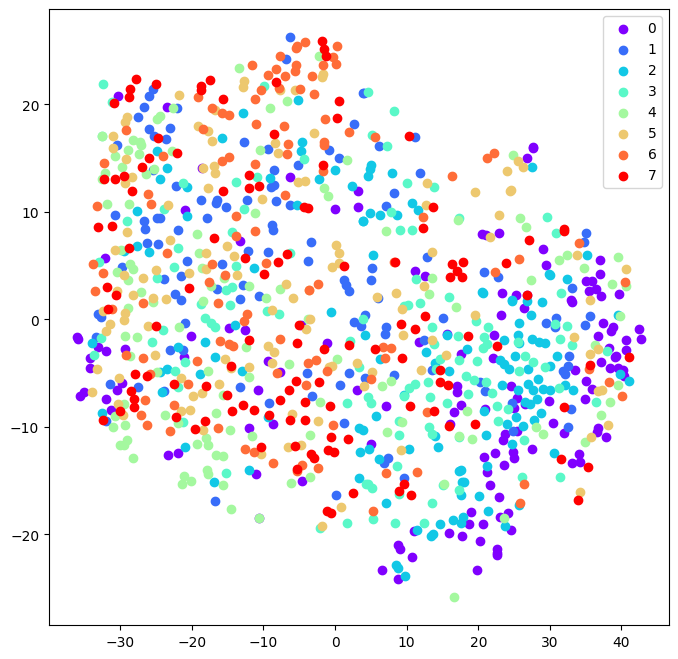

In [48]:
main()